In [28]:
import os 
# os.chdir("facialLandmarkFrontalization/source")
!python3 fill_matrices.py

python3: can't open file '/home/villi/Desktop/PainAssessmentVideo/fill_matrices.py': [Errno 2] No such file or directory


In [29]:
import mediapipe as mp
mp.__version__

'0.10.5'

In [10]:
import cv2
def rect_contains(rect, point):
  return rect[0] <= point[0] < rect[2] and rect[1] <= point[1] < rect[3]

def img_triang(image,landmarks):
  # Define the bounding rectangle for the image
  rect = (0, 0, image.shape[1], image.shape[0])

  # Initialize Subdiv2D with the bounding rectangle
  subdiv = cv2.Subdiv2D(rect)

  # Insert landmark points into Subdiv2D
  for point in landmarks:
    # print(f'points {point}')
    subdiv.insert(point)

  # Get the list of triangles as indices of points
  triangle_list = subdiv.getTriangleList()
  print(f'triangle_list {triangle_list}')
  print(f'triangle_list {triangle_list[0].shape}')
  
  # Convert triangle vertices to integer coordinates
  triangles = []
  for t in triangle_list:
    pt1 = (int(t[0]), int(t[1]))
    pt2 = (int(t[2]), int(t[3]))
    pt3 = (int(t[4]), int(t[5]))
    if rect_contains(rect, pt1) and rect_contains(rect, pt2) and rect_contains(rect, pt3):
      triangles.append((pt1, pt2, pt3))
  print(f'triangles {triangles}')
  return triangles

In [23]:
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np

def img_triang(landmarks):
  # Perform Delaunay triangulation
  tri = Delaunay(landmarks)

  # Plot the points and triangles
  plt.figure(figsize=(6, 6))
  plt.triplot(landmarks[:, 0], landmarks[:, 1], tri.simplices, color='blue')  # Draw triangles
  plt.scatter(landmarks[:, 0], landmarks[:, 1], color='red')  # Draw points

  # Annotate points with their indices
  # for i, (x, y) in enumerate(landmarks):
  #     plt.text(x + 2, y + 2, str(i), color="green", fontsize=12)  # Add index labels

  # Customize plot
  plt.title("Delaunay Triangulation with Indices")
  plt.gca().invert_yaxis()  # Invert y-axis for image coordinate system
  plt.show()
  
def img_triang_cv2(img,landmarks):
  tri = Delaunay(landmarks)
  for triangle in tri.simplices:
    p1 = landmarks[triangle[0]]
    p2 = landmarks[triangle[1]]
    p3 = landmarks[triangle[2]]
    cv2.line(img, tuple(p1), tuple(p2), (0, 0, 255), 1)
    cv2.line(img, tuple(p2), tuple(p3), (0, 0, 255), 1)
    cv2.line(img, tuple(p3), tuple(p1), (0, 0, 255), 1)
  return img


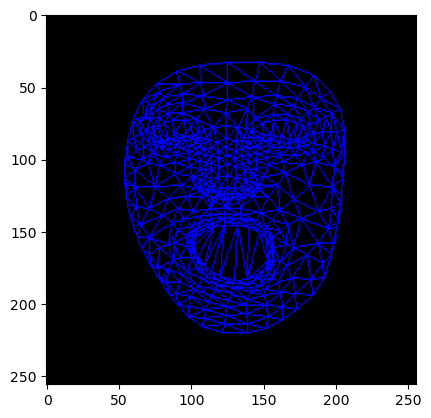

In [24]:
black_img = np.zeros((256, 256, 3), dtype=np.uint8)
unnormalized_landmarks = rot_trans_landmarks.T[:,:2] * (black_img.shape[1], black_img.shape[0])
unnormalized_landmarks = unnormalized_landmarks.astype(int)
img = img_triang_cv2(img=black_img,
               landmarks=unnormalized_landmarks)
plt.imshow(img)

# GIF video per controllare che tutto sia fermo e vari solo l'espressione
# Aggiungere rumore al background (o ingrandire la faccia tc occupi il più possibile)
# 

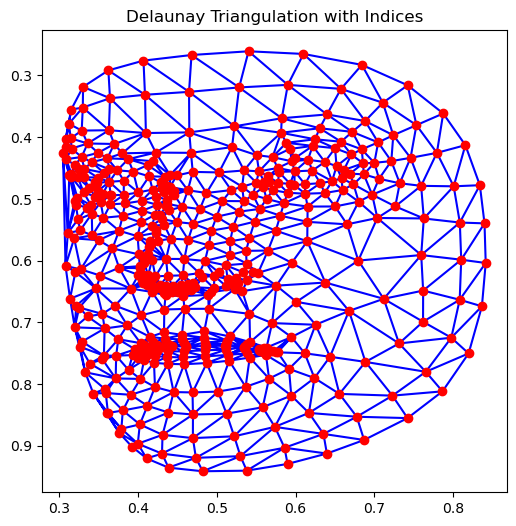

In [ ]:
img_triang(tmp)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1737023208.918132  320956 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1737023208.987893  320956 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1737023209.333596  320956 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


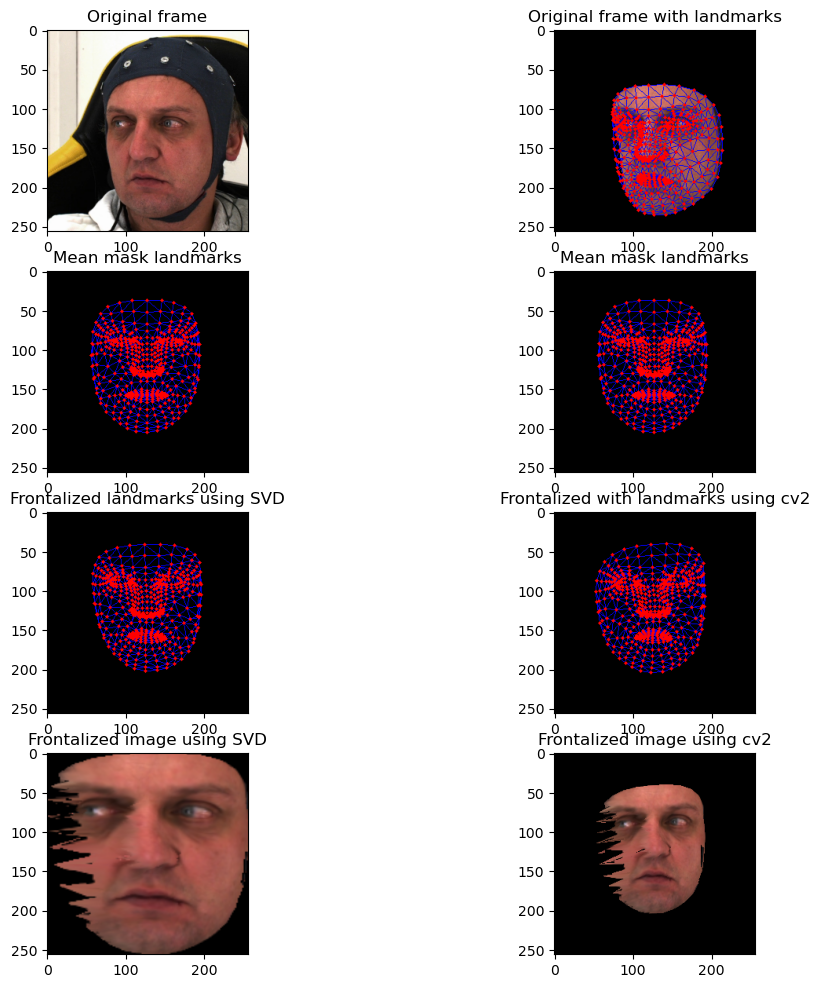

In [1]:
import mediapipe as mp
import cv2
import numpy as np
import os
import custom.faceExtractor as extractor
import matplotlib.pyplot as plt
import pickle
import time 

# from custom.tools_face_elaboration import rigid_transform_3D,get_frontalized_img

# def plot_image_with_title(image, title):
#   fig, ax = plt.subplots(1, 1)
#   plt.title(title)
#   plt.imshow(image)
#   plt.show()

# def get_aligned_frames_from_video(video_path):
#   face_extractor = extractor.FaceExtractor(visionRunningMode='video')
#   list_aligned_frames = face_extractor._get_list_frame(path_video_input=video_path,
#                                                        align=True)
#   return list_aligned_frames, face_extractor

def get_aligned_images_from_list(list_imgs):
  face_extractor = extractor.FaceExtractor(visionRunningMode='image')
  list_aligned_frames = []
  for img in list_imgs:
    list_aligned_frames.append(face_extractor.align_face(img))
  return list_aligned_frames, face_extractor

# def extract_landmarks(face_extractor, ref_frame, timestamp):
#   landmarks = face_extractor.extract_facial_landmarks([(ref_frame, timestamp)])
#   return landmarks

# def plot_landmarks_on_image(face_extractor, landmarks, image, black=False):
#   if black:
#     image = np.zeros(shape=(image.shape),dtype=np.uint8)
#   black_img, _ = face_extractor.plot_landmarks(image=image,
#                          landmarks=landmarks,
#                          connections=None)
#   return np.array(black_img,dtype=np.uint8)

def load_reference_landmarks(path):
  ref_landmarks = pickle.load(open(path, 'rb'))
  ref_landmarks = ref_landmarks['mean_facial_landmarks']
  return ref_landmarks

def get_list_imgs_from_folder(folder_path):
  list_imgs = []
  name_imgs = []
  for img_name in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    list_imgs.append(img)
    name_imgs.append(img_name[:-4])
  return list_imgs,name_imgs


################## Main code ##################
timestamp = time.time()
saving_test_path = os.path.join('test_frontalization_imgs','tests',f'test_{int(timestamp)}')

if not os.path.exists(saving_test_path):
  os.makedirs(saving_test_path)

folder_imgs_path = os.path.join('test_frontalization_imgs','imgs')
list_frames,name_imgs = get_list_imgs_from_folder(folder_imgs_path)
list_aligned_images, face_extractor = get_aligned_images_from_list(list_frames)

ref_landmarks = load_reference_landmarks(os.path.join('partA', 'video', 'mean_face_landmarks_per_subject', 'all_subjects_mean_landmarks.pkl'))
# ref_landmarks = convert_landmarks(face_extractor, ref_landmarks)
# black_img = plot_landmarks_on_image(face_extractor=face_extractor,
#                                     image=list_aligned_images[0],
#                                     black=True,
#                                     landmarks=ref_landmarks)
img_base_landmarks = face_extractor.plot_landmarks_triangulation(image=np.zeros((256, 256, 3), dtype=np.uint8),
                                                                  landmarks=ref_landmarks)

for frame,name_img in zip(list_aligned_images,name_imgs):
  orig_frame = np.copy(frame)
  # orig_frame = np.array(face_extractor.align_face(frame),dtype=np.uint8)
  landmarks = face_extractor.extract_facial_landmarks([(orig_frame, timestamp)])
  landmarks = np.array([[lm.x, lm.y, lm.z] for lm in landmarks[0].face_landmarks[0]])
  orig_frame,_ = face_extractor.extract_frame_oval_from_img(orig_frame,landmarks)
  orig_frame_w_landmarks = face_extractor.plot_landmarks_triangulation(image=orig_frame,
                                                                      landmarks=landmarks)

  frontalized_img_SVD,landmarks_aligned_SVD = face_extractor.frontalize_img(frame=orig_frame,
                                                      ref_landmarks=ref_landmarks,
                                                      frontalization_mode='SVD')
  frontalized_img_cv2,landmarks_aligned_cv2 = face_extractor.frontalize_img(frame=orig_frame,
                                                      ref_landmarks=ref_landmarks,
                                                      frontalization_mode='CV2')
  landmarks_aligned_SVD = face_extractor.plot_landmarks_triangulation(image=np.zeros_like(orig_frame),
                                                                      landmarks=landmarks_aligned_SVD)
  landmarks_aligned_cv2 = face_extractor.plot_landmarks_triangulation(image=np.zeros_like(orig_frame),
                                                                      landmarks=landmarks_aligned_cv2)
  fig, ax = plt.subplots(4,2, figsize=(12,12))
  ax[0,0].imshow(frame)
  ax[0,0].set_title('Original frame')

  ax[0,1].imshow(orig_frame_w_landmarks)
  ax[0,1].set_title('Original frame with landmarks')
  
  ax[1,0].imshow(img_base_landmarks)
  ax[1,0].set_title('Mean mask landmarks')
  ax[1,1].imshow(img_base_landmarks)
  ax[1,1].set_title('Mean mask landmarks')
  
  
  ax[2,0].imshow(landmarks_aligned_SVD)
  ax[2,0].set_title('Frontalized landmarks using SVD')

  ax[2,1].imshow(landmarks_aligned_cv2)
  ax[2,1].set_title('Frontalized with landmarks using cv2')

  ax[3,0].imshow(frontalized_img_SVD)
  ax[3,0].set_title('Frontalized image using SVD')

  ax[3,1].imshow(frontalized_img_cv2)
  ax[3,1].set_title('Frontalized image using cv2')
  # save all the images
  plt.savefig(os.path.join(saving_test_path, f'{name_img}_plot.png'))
  # plt.close()
  break


ref_landmarks_2d (478, 2)
landmarks_2d (478, 2)


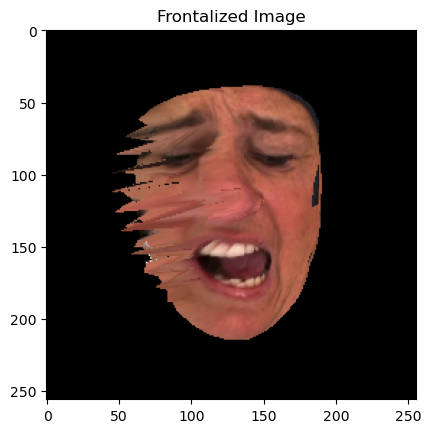

In [6]:

ref_landmarks_2d = cv_transfo_landmarks[:, :2]
landmarks_2d = landmarks[:, :2]
print(f'ref_landmarks_2d {ref_landmarks_2d.shape}')
print(f'landmarks_2d {landmarks_2d.shape}')
frontalized_img_cv2,original_image = apply_delaunay_triangulation(original_image=orig_frame,
                                               frontalized_landmarks=ref_landmarks_2d,
                                               original_landmarks=landmarks_2d)
fig, ax = plt.subplots(1, 1)
plt.title('Frontalized Image')
plt.imshow(frontalized_img_cv2)

In [19]:
import cv2
import av
import time

# Video file path
# video_path = "your_video_file.mp4"
video_path = 'partA/video/video/112016_m_25/112016_m_25-BL1-081.mp4'

# OpenCV reading speed
def opencv_read_speed(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    start_time = time.time()
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
    
    cap.release()
    end_time = time.time()
    print(f"OpenCV: Read {frame_count} frames in {end_time - start_time:.2f} seconds.")

# av (FFmpeg) reading speed
def av_read_speed(video_path):
    container = av.open(video_path)
    frame_count = 0
    start_time = time.time()
    
    for frame in container.decode(video=0):
        frame_count += 1
    
    end_time = time.time()
    print(f"av: Read {frame_count} frames in {end_time - start_time:.2f} seconds.")

# Run the comparison
opencv_read_speed(video_path)
av_read_speed(video_path)


OpenCV: Read 138 frames in 0.18 seconds.
av: Read 138 frames in 0.63 seconds.


frontalization_weights.shape: (137, 136)
landmarks_frontal.shape: (68, 2)


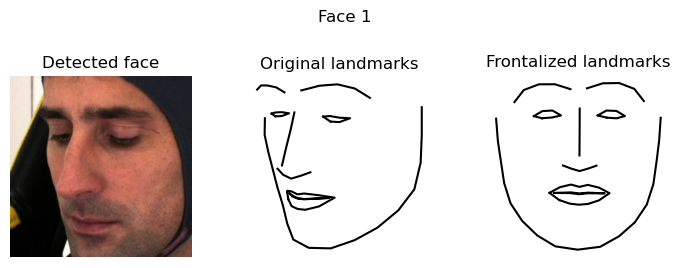

In [130]:
# os.chdir(path="facialLandmarkFrontalization")
import numpy as np
import dlib
import matplotlib.pyplot as plt
from facialLandmarkFrontalization.source.utils import plot_landmarks, frontalize_landmarks, get_landmark_array

# import utils.plot_landmarks, utils.frontalize_landmarks, utils.get_landmark_array
# import imageio
import cv2
from IPython.display import display

plt.close('all')
# facialLandmarkFrontalization
detector = dlib.get_frontal_face_detector() 
predictor = dlib.shape_predictor("facialLandmarkFrontalization/data/shape_predictor_68_face_landmarks.dat") 
frontalization_weights = np.load('facialLandmarkFrontalization/data/frontalization_weights.npy')
print(f'frontalization_weights.shape: {frontalization_weights.shape}')
# image = imageio.imread('../data/faces.jpg')  # load image
image = cv2.imread('facialLandmarkFrontalization/test.png')  # load image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
faces = detector(image)  # detect faces

for i, face in enumerate(faces):
    
    landmarks_raw = predictor(image, face)  # detect landmarks
    landmarks = get_landmark_array(landmarks_raw)
    landmarks_frontal = frontalize_landmarks(landmarks, frontalization_weights)
    print(f'landmarks_frontal.shape: {landmarks_frontal.shape}')
    if landmarks is not None:
        
        # initialize new image
        fig = plt.figure(figsize=(7,3))
        
        plt.subplot(1,3,1)
        plt.title('Detected face')
        x1 = landmarks_raw.rect.left()
        y1 = landmarks_raw.rect.top()
        x2 = x1 + landmarks_raw.rect.width()
        y2 = y1 + landmarks_raw.rect.height()
        plt.imshow(image[y1:y2, x1:x2, :])
        plt.axis(False)
        
        plt.subplot(1,3,2)
        plt.title('Original landmarks')
        
        plt.subplot(1,3,3)
        plt.title('Frontalized landmarks')
        
        plt.suptitle('Face ' + str(i+1))
        plt.tight_layout()
        axes = fig.get_axes()
        
        plot_landmarks(landmarks, axis=axes[1])
        plot_landmarks(landmarks_frontal, axis=axes[2])
        plt.show()
        

# VideoMAEv2 model availables

### Pre-train

| Model | Config | Dataset | 
| :---: | :----  | :-----: | 
| ViT-giant | vit_g_hybrid_pt_1200e | UnlabeledHybrid | 

### Fine-tune
| Model | Config | Dataset | Pre-train | Post-pre-train |
| :---: | :----  | :-----: | :-------: | :------------: |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_ft | K710 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k400_ft | K400 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k400_ft | K400 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k600_ft | K600 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_ssv2_ft | SSv2 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_ucf101_ft | UCF101 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_hmdb51_ft | HMDB51 | UnlabeledHybrid | K710 |

### Distillation from giant
|  Model  | Dataset | Teacher Model  |
| :-----: | :-----: | :-----------: |
| ViT-small | K710 | vit_g_hybrid_pt_1200e_k710_ft |
| ViT-base | K710 | vit_g_hybrid_pt_1200e_k710_ft | 

### Model details

|  model  | frame channels | frame sampling | frame size (H,W) | tubelet size | patch size | emb dim | output tensor | mem(GB) |
| :-----: | :-----: | :-----------: | :-----: | :-----: | :-----------: | :-----: | :-----: |:----|
| giant | 3 | 16 | (224,224) | 2 | (14,14) | 1408 | [8,16,16,1408] | 4.0 |
| base | 3 | 16 | (224,224) | 2 | (16,16) | 768 | [8,14,14,768] | 0.4|
| small | 3 | 16 | (224,224) | 2 | (16,16) | 384 | [8,14,14,1408] | 0.09|
 


CASE 1
flow -> [batch_video,nr_windows=8,(8,14,14,768)] => 
    => spatial mean reduction =>
    =>[batch_video,nr_windows=8,(8,1,1,768)] => 
    => RESHAPE =>
    => [batch_video,nr_windows=8,(8*1*1*768)] =>
    => 2 GRU((6144,512)|dropout(0.5)|(512,512)) + linear proj (512,1) =>
    => [batch_video,1]

CASE 2
flow -> [batch_video,nr_windows=8,(8,14,14,768)] => 
    => spatial mean reduction =>
    =>[batch_video,nr_windows=8,(8,1,1,768)] => 
    => RESHAPE =>
    => [batch_video,nr_windows=8*8,(1*1*768)] =>
    => 2 GRU((768,512)|drop_out(0.3)|(512,512)) + linear proj (512,1) =>
    => [batch_video,1]
    


# Code (w/ lib) 

Add sanity check when init to see if folders and custom methods are created

Kernel: RBF that can handle non-linear pattern
C: Low to avoid overfit
eps:  high values lead to a simpler model but potentially less precise predictions
      low values require tighter predictions, which can make the model more complex

WHAT I HAVE:

CLIPS_REDUCTION values:
  MEAN: 0 (applied in action recognition)
  GRU: lstm (work in progress)

EMBEDDING_REDUCTION values:
  MEAN_TEMPORAL: 1      [keep spatial information]
  MEAN_SPATIAL: (2, 3)  [keep temporal information]
  MEAN_TEMPORAL_SPATIAL: (1, 2, 3) [applied in action recognition]
  GRU: GRU (work in progress)

MODEL_TYPE values:
  VIDEOMAE_v2_S: smaller model
  VIDEOMAE_v2_B: base model
  VIDEOMAE_v2_G_pt_1200e: giant model w/h intermediate fine-tuning
  VIDEOMAE_v2_G_pt_1200e_K710_it_HMDB51_ft: giant model fine-tuned

SAMPLE_FRAME_STRATEGY values:
  UNIFORM: uniform
  SLIDING_WINDOW: sliding_window
  CENTRAL_SAMPLING: central_sampling
  RANDOM_SAMPLING: random_sampling

HEAD
  SVR
____________________________________________________________________________


TESTING SETTINGS GRID_SEARCH
model_type = MODEL_TYPE.VIDEOMAE_v2_B
embedding_reduction = EMBEDDING_REDUCTION.MEAN_TEMPORAL_SPATIAL
clips_reduction = CLIPS_REDUCTION.MEAN
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.UNIFORM

path_labels = os.path.join('partA','starting_point','subsamples_100_400.csv') # 110 samples per class, 400 samples in total
path_dataset = os.path.join('partA','video','video')
k_cross validation = 5 (Stratified K-Fold cross-validator-> The folds are made by preserving the percentage of samples for each class.)

grid_search = {
  'kernel': ['rbf'],
  'C': [0.1, 1, 10],
  'epsilon': [0.1, 1, 10, 100],
}

Form table we have:
  best_estimator ={
    kernel:'rbf',
    'C': [0.1, 1, 10]
    'epsilon':[10, 100]
  }

<div style="overflow-x: auto;">

## PSPI from (Action Units)
Pain expression is widely characterized by the activation of a small set of facial muscles and coded by a set of
corresponding actions units (AUs): 
| Action units  | Meaning              | Range   |
|----------------|----------------------|---------|
| AU 4          | brow lowering        | 0 to 5  |
| AU 6 and AU 7 | orbital tightening   | 0 to 5  |
| AU 9 and AU 10| levator labii raise  | 0 to 5  |
| AU 43         | eye closure          | 0 or 1  |
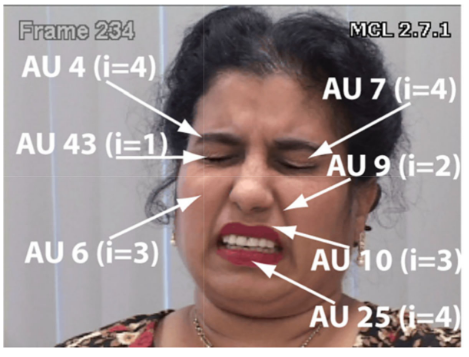

STEPS for preprocessing:
1) Align faces by fixing the inter-ocular distance.
2) Compute mean facial shape by averaging all of the landmark points in the roughly aligned faces.
3) Warp each face in the database to the average face using piece-wise linear warping,where the facial pieces are formed using Delaunay triangulation.
4) Crop out the normalized faces by forming a mask with the convex hull of the landmark points resulting in 224×224 images

In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
import custom.faceExtractor as extractor
import os
import time
import pickle
import custom.tools as tools

import numpy as np
import custom.faceExtractor as extractor
import os
import time
import cv2
import pickle
import custom.tools as tools
import matplotlib.pyplot as plt

root_video_path = 'partA/video/video'
csv_array,cols = tools.get_array_from_csv(csv_path=os.path.join('partA','starting_point','samples.csv'))
list_subject_name = np.unique(csv_array[:,1])
face_ln_saving_folder = 'partA/video/mean_face_landmarks_per_subject'
saving_plot_landmarks_folder = os.path.join(face_ln_saving_folder,'plot_landmarks')
if not os.path.exists(saving_plot_landmarks_folder):
  os.makedirs(saving_plot_landmarks_folder)
if not os.path.exists(face_ln_saving_folder):
  os.makedirs(face_ln_saving_folder)
face_extractor = extractor.FaceExtractor()
start = time.time()
count = 0

for subject_name in list_subject_name:
  folder_path = os.path.join(root_video_path, subject_name)
  all_videos = os.listdir(folder_path)
  sample_video_path = [os.path.join(folder_path, video) for video in all_videos]
  all_mean_facial_landmarks,count_frame=face_extractor.get_mean_facial_landmarks(list_video_path=sample_video_path[:3],
                                                                                 align=True,
                                                                                 numpy_view=True)
  dict_subject = {'subject_name':subject_name,
                  'mean_facial_landmarks':all_mean_facial_landmarks,
                  'count_frame':count_frame}
  
  with open(os.path.join(face_ln_saving_folder,subject_name+'.pkl'), 'wb') as f:
    pickle.dump(dict_subject, f)
  all_mean_facial_landmarks = face_extractor.convert_from_numpy_to_NormalizedLandmark(all_mean_facial_landmarks)
  img = np.zeros((256,256,3))
  annotated_img,_ = face_extractor.plot_landmarks(image=img,landmarks=all_mean_facial_landmarks,connections=face_extractor.FACE_TESSELATION)
  
  # print(np.max(annotated_img))
  # cv2.imwrite(os.path.join(saving_plot_landmarks_folder,subject_name+'.png'),annotated_img)
  # fig, ax = plt.subplots(figsize=(10,10))
  # im = ax.imshow(annotated_img/255,origin='lower')
  # plt.savefig(os.path.join(saving_plot_landmarks_folder,subject_name+'.png'))
  total_time = time.time()-start
  count += 1
  expected_time = total_time/count*len(list_subject_name)
  print('-'*30)
  print(f'{subject_name} saved in path {os.path.join(face_ln_saving_folder,subject_name+".pkl")}')
  print(f'Processed {count}/{len(list_subject_name)} subjects')
  print(f'Expected end: {int(expected_time/60/60)} h {int(expected_time/60)%60} m {int(expected_time)%60} s')
  print(f'Total time  : {int(total_time/60/60)} h {int(total_time/60)%60} m {int(total_time)%60} s')
  print('-'*30)
  


ModuleNotFoundError: No module named 'torch'

In [36]:
import matplotlib.pyplot as plt
import custom.tools as tools
import numpy as np
import os
import pickle
import custom.faceExtractor as extractor

csv_array,cols = tools.get_array_from_csv(csv_path=os.path.join('partA','starting_point','samples.csv'))
list_subject_name = np.unique(csv_array[:,1])
all_mean_facial_landmarks = np.zeros((478,3),dtype=np.float32)
face_ln_saving_folder = 'partA/video/mean_face_landmarks_per_subject'
count = 0
face_extractor = extractor.FaceExtractor()
for subject_name in list_subject_name:
  count+=1
  with open(os.path.join(face_ln_saving_folder,subject_name+'.pkl'), 'rb') as f:
    dict_subject = pickle.load(f)
    mean_facial_landmarks = dict_subject['mean_facial_landmarks']
    count_frame = dict_subject['count_frame']
        
  black_img = np.zeros((256,256,3), dtype=np.uint8)
  
  all_mean_facial_landmarks += mean_facial_landmarks

all_mean_facial_landmarks /= len(list_subject_name)  
ln = face_extractor.convert_from_numpy_to_NormalizedLandmark(all_mean_facial_landmarks)
annotated_image,_ = face_extractor.plot_landmarks(image=black_img, 
                                                landmarks=ln,
                                                connections=face_extractor.FACE_TESSELATION)

dict_subject = {'mean_facial_landmarks':all_mean_facial_landmarks,
                'count_subject':count}

with open(os.path.join(face_ln_saving_folder,'all_subjects_mean_landmarks.pkl'), 'wb') as f:
  pickle.dump(dict_subject, f)
  print('All subjects mean landmarks saved in path:',os.path.join(face_ln_saving_folder,'all_subjects_mean_landmarks.pkl'))
  
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(annotated_image[:,:,::-1]/255)

ModuleNotFoundError: No module named 'sklearn'

In [2]:
%matplotlib notebook
!python3 facialLandmarkFrontalization/source/example_frontalize_dlib_singleimage.py

Figure(700x300)
Figure(700x300)


In [46]:
# Read the input file and process the data
from collections import defaultdict

# File name containing the input data
file_name = 'partA/video/mean_face_landmarks_per_subject/video/logs1736508431/annotation.txt'

# Dictionary to store the counts for each sample and timestamp
align_timestamps = defaultdict(set)
detection_timestamps = defaultdict(set)
count = 0
# Parse the input file
with open(file_name, 'r') as file:
  lines = file.readlines()
dict_missing = {}
next = False
for line in lines:
    # line = line
    if line.startswith('sample:') and next:
        sample = line.split('sample:')[-1].split()[0]
        dict_missing[sample] = dict_missing.get(sample,0)+1
        timestamp = line.split('timestamp_h_m_s:')[-1]
        align_timestamps[sample].add(timestamp)
        count += 1
        next = False
    if line.startswith('type:align'):
      next = True

print(f'Video with no detection {len(dict_missing)}')
print(f'COunt frame {count}\n')
count_frame = 0
for k,v in dict_missing.items():
  print(k,v)
  count_frame += v

Video with no detection 27
COunt frame 567

072609_w_23-PA1-053.mp4 45
080609_w_27-BL1-098.mp4 30
081714_m_36-PA1-077.mp4 5
082714_m_22-PA4-055.mp4 15
091809_w_43-PA4-070.mp4 2
092514_m_50-BL1-084.mp4 4
092514_m_50-PA2-029.mp4 17
092514_m_50-PA3-027.mp4 48
092813_w_24-PA1-038.mp4 14
101015_w_43-PA3-079.mp4 13
101114_w_37-BL1-100.mp4 7
101216_m_40-BL1-100.mp4 48
101309_m_48-PA4-023.mp4 1
101814_m_58-BL1-090.mp4 10
101814_m_58-PA3-001.mp4 25
101814_m_58-PA3-014.mp4 45
101814_m_58-PA4-022.mp4 26
101814_m_58-PA4-026.mp4 13
101814_m_58-PA4-027.mp4 25
101814_m_58-PA4-028.mp4 21
101814_m_58-PA4-053.mp4 38
101814_m_58-PA4-060.mp4 17
101814_m_58-PA4-066.mp4 37
101814_m_58-PA4-069.mp4 32
101814_m_58-PA4-076.mp4 3
111914_w_63-BL1-098.mp4 6
120514_w_56-PA4-041.mp4 20


In [12]:
import dlib
import os
import cv2
from imutils import face_utils
import matplotlib.pyplot as plt

predictor_path = os.path.join('landmark_model','dlib_shape_predictor_68_face_landmarks.dat')
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# image = cv2.imread("apple.jpeg")
image = cv2.imread("output.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = detector(gray)
print(f'faces : {len(faces)}')
for face in faces:
  shape = predictor(gray, face)
  print(f'shape : {shape}')
  landmarks = face_utils.shape_to_np(shape)
  print(f'landmarks: {landmarks}')
  for (x, y) in landmarks:
      cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

cv2.imshow("Landmarks", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

faces : 1
shape : <_dlib_pybind11.full_object_detection object at 0x739301b1c930>
landmarks: [[170 304]
 [172 351]
 [180 396]
 [187 439]
 [200 483]
 [225 522]
 [263 553]
 [306 576]
 [355 582]
 [401 573]
 [441 552]
 [474 521]
 [494 484]
 [503 442]
 [509 399]
 [518 357]
 [520 312]
 [205 271]
 [228 251]
 [259 241]
 [293 243]
 [324 253]
 [391 252]
 [421 245]
 [452 245]
 [481 255]
 [499 277]
 [358 294]
 [358 328]
 [358 361]
 [358 394]
 [319 418]
 [338 423]
 [358 428]
 [377 424]
 [394 418]
 [241 305]
 [262 293]
 [286 292]
 [309 306]
 [287 310]
 [262 312]
 [398 307]
 [422 292]
 [445 294]
 [466 307]
 [446 314]
 [422 313]
 [294 477]
 [317 465]
 [341 457]
 [357 462]
 [374 457]
 [398 465]
 [420 475]
 [399 494]
 [377 504]
 [358 507]
 [341 505]
 [318 496]
 [305 478]
 [341 476]
 [358 477]
 [375 476]
 [409 476]
 [375 475]
 [358 478]
 [342 476]]


In [35]:
#Plot landmarks for subject and the mean_facial_landmarks

import matplotlib.pyplot as plt
import custom.tools as tools
import custom.faceExtractor as extractor
import numpy as np
import os

csv_array,cols = tools.get_array_from_csv(csv_path=os.path.join('partA','starting_point','samples.csv'))
list_subject_name = np.unique(csv_array[:,1])
face_ln_saving_folder = 'partA/video/mean_face_landmarks_per_subject'
saving_plot = os.path.join(face_ln_saving_folder,'plot_landmarks')
list_landmarks = []
if not os.path.exists(saving_plot):
  os.makedirs(saving_plot)
if not os.path.exists(face_ln_saving_folder):
  os.makedirs(face_ln_saving_folder)
for subject in list_subject_name:
  with open(os.path.join(face_ln_saving_folder,subject+'.pkl'), 'rb') as f:
    dict_subject = pickle.load(f)
    mean_facial_landmarks = dict_subject['mean_facial_landmarks']
    mean_facial_landmarks = face_extractor.convert_from_numpy_to_NormalizedLandmark(mean_facial_landmarks)
    black_img = np.zeros((256,256,3), dtype=np.uint8)
    annotated_image,_ = face_extractor.plot_landmarks(image=black_img, 
                                                landmarks=mean_facial_landmarks,
                                                connections=face_extractor.FACE_TESSELATION)
    plt.imshow(annotated_image[:,:,::-1]/255,origin='lower')
    plt.title(subject)
    plt.savefig(os.path.join(saving_plot,subject+'.png'))
    plt.show()
    
subject = 'all_subjects_mean_landmarks'
with open(os.path.join(face_ln_saving_folder,subject+'.pkl'), 'rb') as f:
  dict_subject = pickle.load(f)
  mean_facial_landmarks = dict_subject['mean_facial_landmarks']
  mean_facial_landmarks = face_extractor.convert_from_numpy_to_NormalizedLandmark(mean_facial_landmarks)
  black_img = np.zeros((256,256,3), dtype=np.uint8)
  annotated_image,_ = face_extractor.plot_landmarks(image=black_img, 
                                                landmarks=mean_facial_landmarks,
                                                connections=face_extractor.FACE_TESSELATION)
  plt.imshow(annotated_image[:,:,::-1]/255,origin='lower')
  plt.title(subject)
  plt.savefig(os.path.join(saving_plot,subject+'.png'))
  plt.show()

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# Analyze the error during face extraction

import custom.tools as tools
import custom.faceExtractor as extractor
import numpy as np
import os
import matplotlib.pyplot as plt

def read_not_detection_log(log_path):
  with open(log_path,'r') as f:
    lines = f.readlines()
    dict_not_detection = {
      'path':[],
      'frame_nr':[]
    }
    for line in lines:
      dict_not_detection['path'].append(line.split(',')[0].strip())
      dict_not_detection['frame_nr'].append(int(line.split(',')[1].strip()))
    # tmp = [line.split(',')[-1].strip() for line in lines]
    dict_not_detection['path'] = np.array(dict_not_detection['path'])
    dict_not_detection['frame_nr'] = np.array(dict_not_detection['frame_nr'])
  return dict_not_detection

csv_array,cols = tools.get_array_from_csv(csv_path=os.path.join('partA','starting_point','samples.csv'))
list_subject_name = np.array(csv_array[:,1])
list_sample_name = np.array(csv_array[:,5])
# partA/video/video/071911_w_24/071911_w_24-BL1-097.mp4
sample_video_path = [os.path.join('partA','video','video','071911_w_24','071911_w_24-BL1-097.mp4')]
# list_video_path = [os.path.join('partA','video','video',subject,sample+'.mp4') for subject,sample in zip(list_subject_name,list_sample_name)]
face_extractor = extractor.FaceExtractor()

count_frame = 0
error_log_file = os.path.join('partA','video','mean_face_landmarks_per_subject','no_detection_log.txt')
dict_not_detection = read_not_detection_log(error_log_file)
video_path_no_detect = dict_not_detection['path']
frame_nr_no_detect = dict_not_detection['frame_nr']
idx = 0
loop_nr = 0


for video_path in sample_video_path:
  loop_nr += 1
  # print(f'loop {loop_nr}/{len(list_video_path)}')
  if video_path in video_path_no_detect:
    frame_list = face_extractor._get_list_frame(video_path, align=False)
    detection_result_list = face_extractor.extract_facial_landmarks(frame_list)
    idx_video_bool = video_path_no_detect == video_path
    for frame_nr,detection_result in enumerate(detection_result_list):
      if frame_nr in frame_nr_no_detect:
        # print(f'frame {frame_nr} in video {video_path} not detected')
        frame,timestamp = frame_list[frame_nr]
        if len(detection_result.face_landmarks) == 0:
          print(f'frame {frame_nr} in video {video_path} not detected')
          fig,ax = plt.subplots(figsize=(10,10))
          fig.suptitle(f'frame {frame_nr} in video {video_path} not detected')
          plt.imshow(frame[:,:,::-1]/255)
        else:
          landmarks = detection_result.face_landmarks[0]
          annotated_image,_ = face_extractor.plot_landmarks(image=frame, 
                                                          landmarks=landmarks,
                                                          connections=face_extractor.FACE_TESSELATION)
      # fig,ax = plt.subplots(figsize=(10,10))
      
      # plt.imshow(annotated_image[:,:,::-1]/255)
      
    # if detection_result is None or len(detection_result.face_landmarks) == 0:
    # else:
      # landmarks = self.get_numpy_array(detection_result.face_landmarks[0])
      # landmarks = face_extractor.center_wrt_nose(detection_result.face_landmarks[0])
      # landmarks = self.convert_from_numpy_to_NormalizedLandmark(landmarks)
  

# if numpy_view:
#   return mean_face_landmarks,count_frame
# else:
#   return [mp.tasks.components.containers.NormalizedLandmark(x=ln[0],y=ln[1],z=ln[2]) for ln in mean_face_landmarks],count_frame

In [6]:
import cv2
import numpy as np
cv2.__version__
np.__version__

'1.26.4'

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)


ModuleNotFoundError: No module named 'torch'

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import custom.faceExtractor as extractor
import os
import time
import cv2
import pickle
import custom.tools as tools
import matplotlib.pyplot as plt
import math

csv_path = os.path.join("partA", "starting_point", "samples.csv")
csv_array,_ = tools.get_array_from_csv(csv_path=csv_path)
video_folder_path = os.path.join("partA", "video", "video")
extracted_video_folder_path = os.path.join("partA", "video", "extracted_video")
landmarks_folder_path = os.path.join("partA", "video", "mean_face_landmarks_per_subject")
# ['subject_id', 'subject_name', 'class_id', 'class_name', 'sample_id', 'sample_name']
sample_video_path = [os.path.join(video_folder_path, sample[1],sample[5]+".mp4") for sample in csv_array]
face_extractor = extractor.FaceExtractor()
count = 0
start = time.time()
img_all_black = np.zeros((256,256,3),dtype=np.uint8)
saving_path_ln = os.path.join(landmarks_folder_path, "all_subjects_mean_landmarks.pkl")

with open(saving_path_ln, 'rb') as f:
  reference_landmarks = pickle.load(f)
  reference_landmarks = face_extractor.convert_from_numpy_to_NormalizedLandmark(reference_landmarks['mean_facial_landmarks'])

# select_sample = os.path.join()


for subject_name,sample_name in zip(csv_array[:,1],csv_array[:,5]):
  # sample_video_path = os.path.join(video_folder_path,subject_name,sample_name+'.mp4')
  sample_video_path = 'partA/video/video/101916_m_40/101916_m_40-PA3-052.mp4'
  frame_list = face_extractor._get_list_frame(sample_video_path, 
                                              align=True)
  list_landmarks_video = face_extractor.extract_facial_landmarks(frame_list=frame_list)
  for landmarks_frame,(frame,_) in zip(list_landmarks_video,frame_list):
    centered_lm = face_extractor.center_wrt_nose(landmarks_frame.face_landmarks[0])
    # centered_lm = landmarks_frame.face_landmarks[0]
    centered_ref_lm = np.array([[lm.x,lm.y,lm.z] for lm in reference_landmarks])
    centered_ref_lm = face_extractor.convert_from_numpy_to_NormalizedLandmark(centered_ref_lm)
    print(f'Nose ref: {reference_landmarks[face_extractor.NOSE_INDEX]}')
    print(f'Nose: {centered_lm[face_extractor.NOSE_INDEX]}')
    centered_lm_plot,_ = face_extractor.plot_landmarks(image=img_all_black,
                                  landmarks=centered_lm,
                                  connections=face_extractor.FACE_TESSELATION)
    centered_ref_lm_plot,_ = face_extractor.plot_landmarks(image=img_all_black,
                                  landmarks=centered_ref_lm,
                                  connections=face_extractor.FACE_TESSELATION)
    # ref_lm,_ = face_extractor.plot_landmarks(image=img_all_black,
    #                                           landmarks=reference_landmarks,
    #                                           connections=face_extractor.FACE_TESSELATION)
    # non_centered_lm, _ = face_extractor.plot_landmarks(image=img_all_black,
    #                               landmarks=landmarks_frame.face_landmarks[0],
    #                               connections=face_extractor.FACE_TESSELATION)
    fig,ax = plt.subplots(figsize=(8,8))
    fig.suptitle(f'Centered landmarks')
    plt.imshow(centered_lm_plot/255)

    fig,ax = plt.subplots(figsize=(8,8))
    fig.suptitle(f'Centered ref landmarks')
    plt.imshow(centered_ref_lm_plot/255)
    
    # fig,ax = plt.subplots(figsize=(8,8))
    # fig.suptitle(f'Ref landmarks (already centered)')
    # plt.imshow(ref_lm[:,:,::-1]/255)
    
    # if centered_lm[face_extractor.NOSE_INDEX] != centered_ref_lm[face_extractor.NOSE_INDEX]:
    #   raise ValueError('Nose not aligned')
    # print(f'centered_lm: {centered_lm}')
    # print(f'centered_ref_lm: {centered_ref_lm}')     
    # frame = face_extractor._extract_face_oval_from_img(img=frame,
    #                                                   routes=reference['mean_facial_landmarks'])
    # print(f'annotated_img: {annotated_img.shape}')
    # print(f'frame_list[0][0]: {frame_list[0][0].shape}')
    
    # centered_ref_lm = np.array([[lm.x,lm.y] for lm in centered_ref_lm])
    
    # size = (256,256)
    reference_landmarks = np.array([[lm.x,lm.y] for lm in centered_ref_lm])
    src_points = np.array([[lm.x,lm.y] for lm in centered_lm])
    dst_points = reference_landmarks
    # cv2.estimateAffine3D
    H, mask = cv2.estimateAffine2D(from_=src_points,
                                          to=dst_points)
    # H = cv2.estimateAffine3D(src=src_points,
    #                                dst=dst_points)
    # H = H[1]
    print(f'srcPoints: {src_points[4:8]}')
    print(f'dstPoints: {dst_points[4:8]}')
    print(f'H: {H}')
    annotated_img,ln_coords = face_extractor.plot_landmarks(image=frame,
                                                landmarks=landmarks_frame.face_landmarks[0],
                                                connections=face_extractor.FACE_TESSELATION)
    
    # annotated_frame,ln_coords_frame = face_extractor.plot_landmarks(image=frame,
    #                                             landmarks=centered_lm,
    #                                             connections=face_extractor.FACE_OVAL_ROUTE)
    height, width = frame.shape[:2]
    im_warped = cv2.warpPerspective(src=frame, M=H, dsize=(height,width))
    # warp frame using the homography
    # frame = cv2.warpPerspective(src=frame, M=H, dsize=(256,256))
    print(f'frame: {frame.shape}')
    fig,ax = plt.subplots(figsize=(8,8))
    fig.suptitle(f'Annotated frame')
    plt.imshow(annotated_img/255)
    #plot frame_list[0][0]
    fig,ax = plt.subplots(figsize=(8,8))
    fig.suptitle(f'Frame')
    plt.imshow(frame/255)
    fig,ax = plt.subplots(figsize=(8,8))
    fig.suptitle(f'Warped Img')
    plt.imshow(im_warped/255)
    plt.show()
    break
  
  # # face_extractor.warp_face(target_img=fr)
  # if count % 1 == 0:
  #   print('---------------------------------')
  #   print(f'Processed {count}/{len(csv_array[:,5])} videos')
  #   print(f'Total time: {time.time()-start:.2f} s')
  #   print('---------------------------------')
  #   # clear console output
  break

In [6]:
import cv2
import time

def process_video_with_cpu(video_path):
    """Read video frames using CPU."""
    print("Processing video with CPU...")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    start_time = time.time()
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Process frame (no operation in this example)
        frame_count += 1

    end_time = time.time()
    cap.release()
    print(f"CPU: Processed {frame_count} frames in {end_time - start_time:.2f} seconds.")

def process_video_with_gpu(video_path):
    """Read video frames using GPU."""
    print("Processing video with GPU...")
    cap = cv2.VideoCapture(video_path, cv2.CAP_FFMPEG)
    # Enable GPU decoding
    if cv2.cuda.getCudaEnabledDeviceCount() > 0:
      
        gpu_cap = cv2.cudacodec.createVideoReader(video_path)
    else:
        print("Error: No CUDA-enabled GPU found.")
        return

    start_time = time.time()
    frame_count = 0

    while True:
        ret, gpu_frame = gpu_cap.nextFrame()
        if not ret:
            break
        # Download frame from GPU to CPU (if needed)
        frame = gpu_frame.download()
        # Process frame (no operation in this example)
        frame_count += 1

    end_time = time.time()
    print(f"GPU: Processed {frame_count} frames in {end_time - start_time:.2f} seconds.")

video_path = "partA/video/video/071309_w_21/071309_w_21-BL1-081.mp4"  # Replace with the path to your video file

# CPU processing
process_video_with_cpu(video_path)

# GPU processing
process_video_with_gpu(video_path)


Processing video with CPU...
CPU: Processed 138 frames in 0.22 seconds.
Processing video with GPU...


AttributeError: module 'cv2' has no attribute 'cudacodec'

In [2]:
import cv2
print(cv2.getBuildInformation())



General configuration for OpenCV 4.10.0 =====================================
  Version control:               4.10.0

  Extra modules:
    Location (extra):            /home/villi/opencv_contrib/modules
    Version control (extra):     4.10.0

  Platform:
    Timestamp:                   2025-01-12T15:51:39Z
    Host:                        Linux 6.8.0-51-generic x86_64
    CMake:                       3.22.1
    CMake generator:             Unix Makefiles
    CMake build tool:            /usr/bin/gmake
    Configuration:               Release

  CPU/HW features:
    Baseline:                    SSE SSE2 SSE3
      requested:                 SSE3
    Dispatched code generation:  SSE4_1 SSE4_2 FP16 AVX AVX2 AVX512_SKX
      requested:                 SSE4_1 SSE4_2 AVX FP16 AVX2 AVX512_SKX
      SSE4_1 (18 files):         + SSSE3 SSE4_1
      SSE4_2 (2 files):          + SSSE3 SSE4_1 POPCNT SSE4_2
      FP16 (1 files):            + SSSE3 SSE4_1 POPCNT SSE4_2 FP16 AVX
      AVX (9 files

In [1]:
import cv2
print(cv2.cuda.getCudaEnabledDeviceCount())

error: OpenCV(4.10.0) /home/villi/opencv/modules/core/src/cuda_info.cpp:62: error: (-217:Gpu API call) unknown error in function 'getCudaEnabledDeviceCount'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


W0000 00:00:1736270160.172815  818752 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Nose ref: NormalizedLandmark(x=0.5, y=0.5, z=0.5, visibility=None, presence=None)
Nose: NormalizedLandmark(x=0.5, y=0.5, z=0.5, visibility=None, presence=None)
srcPoints: [[128.10466003 121.2603302 ]
 [127.94682312 112.41519165]
 [127.33740234  90.62123108]
 [ 81.80128479  86.36772156]]
dstPoints: [[128.01374054 121.51879883]
 [127.88423157 113.17372131]
 [127.59614563  92.92750549]
 [ 83.96168518  90.23086548]]
H: [[ 9.90050176e-01  1.50373862e-03  2.34317989e+00]
 [-1.50373862e-03  9.90050176e-01  3.97636705e+00]]
frame: (256, 256, 3)
---------------------------------
Processed 0/8700 videos
Total time: 4.06 s
---------------------------------


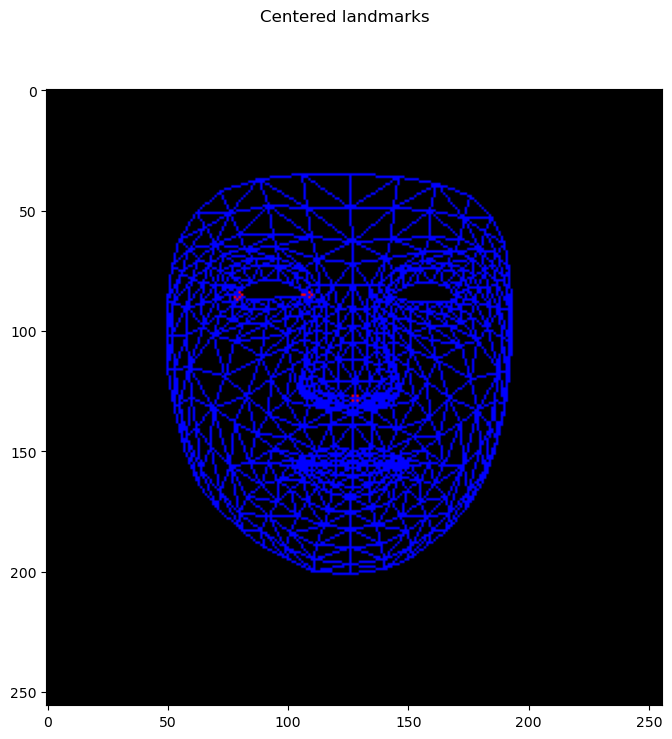

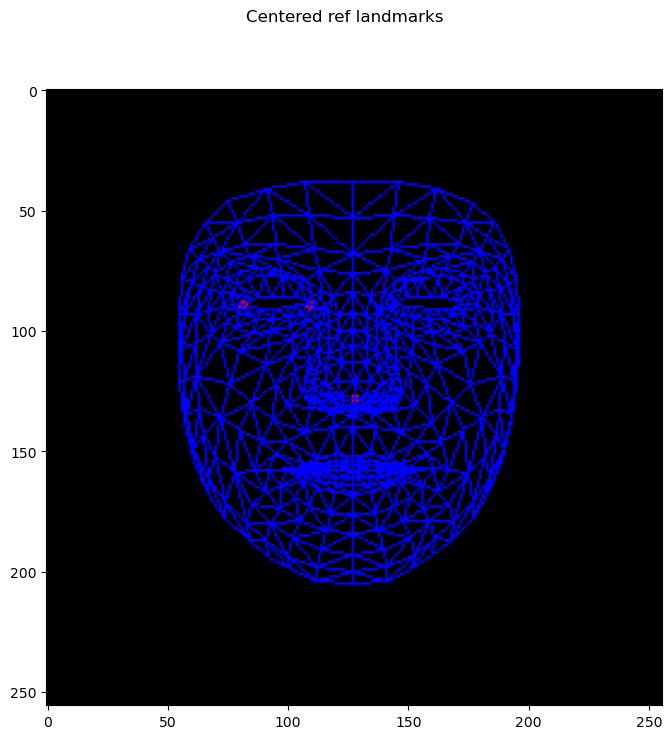

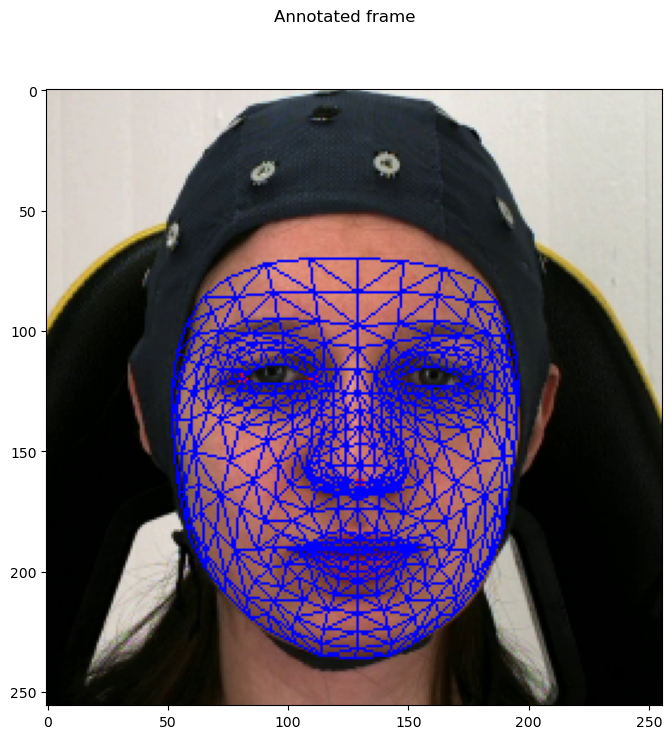

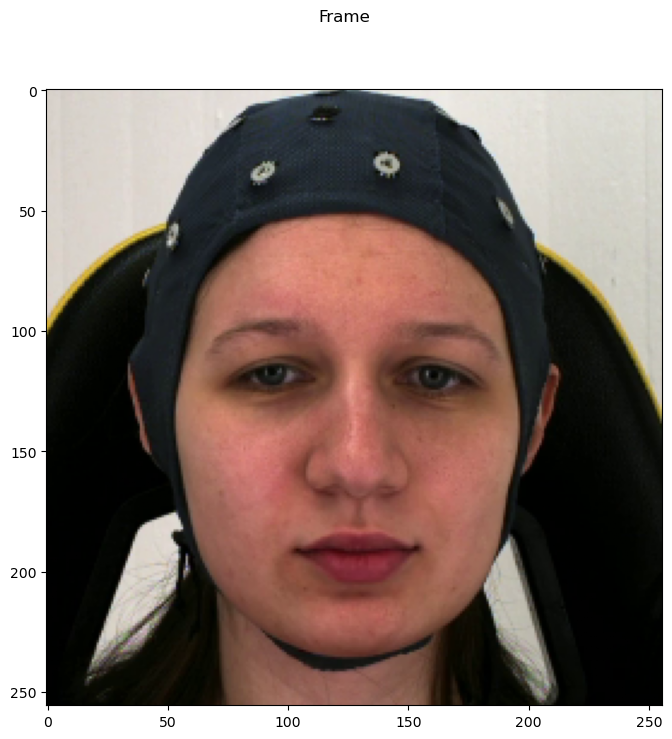

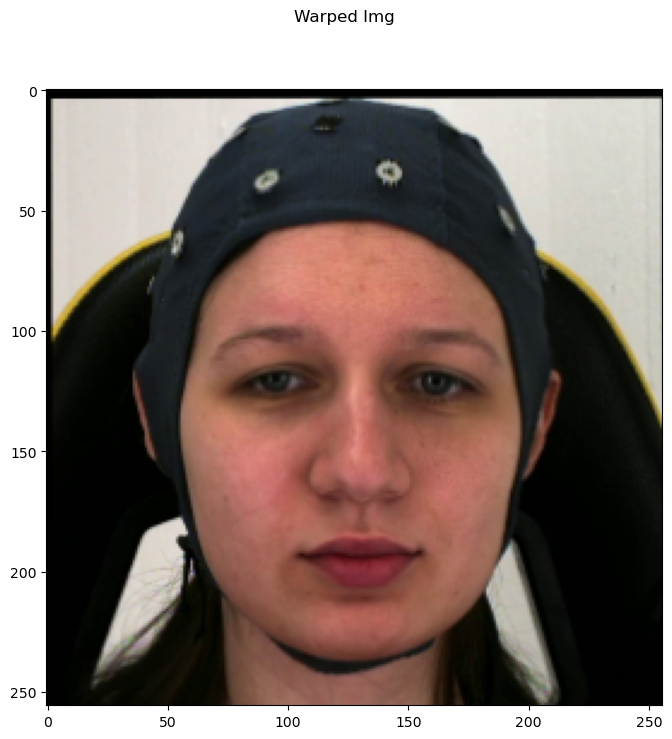

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import custom.faceExtractor as extractor
import os
import time
import cv2
import pickle
import custom.tools as tools
import matplotlib.pyplot as plt
import math

csv_path = os.path.join("partA", "starting_point", "samples.csv")
csv_array,_ = tools.get_array_from_csv(csv_path=csv_path)
video_folder_path = os.path.join("partA", "video", "video")
extracted_video_folder_path = os.path.join("partA", "video", "extracted_video")
landmarks_folder_path = os.path.join("partA", "video", "mean_face_landmarks_per_subject")
# ['subject_id', 'subject_name', 'class_id', 'class_name', 'sample_id', 'sample_name']
sample_video_path = [os.path.join(video_folder_path, sample[1],sample[5]+".mp4") for sample in csv_array]
face_extractor = extractor.FaceExtractor()
count = 0
start = time.time()
img_all_black = np.zeros((256,256,3),dtype=np.uint8)
saving_path_ln = os.path.join(landmarks_folder_path, "all_subjects_mean_landmarks.pkl")

with open(saving_path_ln, 'rb') as f:
  reference_landmarks = pickle.load(f)
  reference_landmarks = face_extractor.convert_from_numpy_to_NormalizedLandmark(reference_landmarks['mean_facial_landmarks'])

for subject_name,sample_name in zip(csv_array[:,1],csv_array[:,5]):
  sample_video_path = os.path.join(video_folder_path,subject_name,sample_name+'.mp4')
  frame_list = face_extractor._get_list_frame(sample_video_path, 
                                              align=True)
  list_landmarks_video = face_extractor.extract_facial_landmarks(frame_list=frame_list)
  for landmarks_frame,(frame,_) in zip(list_landmarks_video,frame_list):
    centered_lm = face_extractor.center_wrt_nose(landmarks_frame.face_landmarks[0])
    # centered_lm = landmarks_frame.face_landmarks[0]
    centered_ref_lm = np.array([[-lm.x+1,-lm.y + 1.0,lm.z] for lm in reference_landmarks])
    centered_ref_lm = face_extractor.convert_from_numpy_to_NormalizedLandmark(centered_ref_lm)
    print(f'Nose ref: {reference_landmarks[face_extractor.NOSE_INDEX]}')
    print(f'Nose: {centered_lm[face_extractor.NOSE_INDEX]}')
    centered_lm_plot,_ = face_extractor.plot_landmarks(image=img_all_black,
                                  landmarks=centered_lm,
                                  connections=face_extractor.FACE_TESSELATION)
    centered_ref_lm_plot,_ = face_extractor.plot_landmarks(image=img_all_black,
                                  landmarks=centered_ref_lm,
                                  connections=face_extractor.FACE_TESSELATION)
    # ref_lm,_ = face_extractor.plot_landmarks(image=img_all_black,
    #                                           landmarks=reference_landmarks,
    #                                           connections=face_extractor.FACE_TESSELATION)
    # non_centered_lm, _ = face_extractor.plot_landmarks(image=img_all_black,
    #                               landmarks=landmarks_frame.face_landmarks[0],
    #                               connections=face_extractor.FACE_TESSELATION)
    fig,ax = plt.subplots(figsize=(8,8))
    fig.suptitle(f'Centered landmarks')
    plt.imshow(centered_lm_plot[:,:,::-1]/255)

    fig,ax = plt.subplots(figsize=(8,8))
    fig.suptitle(f'Centered ref landmarks')
    plt.imshow(centered_ref_lm_plot[:,:,::-1]/255)
    
    # fig,ax = plt.subplots(figsize=(8,8))
    # fig.suptitle(f'Ref landmarks (already centered)')
    # plt.imshow(ref_lm[:,:,::-1]/255)
    
    # if centered_lm[face_extractor.NOSE_INDEX] != centered_ref_lm[face_extractor.NOSE_INDEX]:
    #   raise ValueError('Nose not aligned')
    # print(f'centered_lm: {centered_lm}')
    # print(f'centered_ref_lm: {centered_ref_lm}')     
    # frame = face_extractor._extract_face_oval_from_img(img=frame,
    #                                                   routes=reference['mean_facial_landmarks'])
    # print(f'annotated_img: {annotated_img.shape}')
    # print(f'frame_list[0][0]: {frame_list[0][0].shape}')
    
    # centered_ref_lm = np.array([[lm.x,lm.y] for lm in centered_ref_lm])
    
    reference_landmarks = np.array([[lm.x,lm.y] for lm in centered_ref_lm])
    size = (256,256)
    src_points = np.array([[lm.x,lm.y] for lm in centered_lm])*size
    dst_points = reference_landmarks*size
    
    H, mask = cv2.estimateAffinePartial2D(from_=src_points,
                                          to=dst_points)
    
    print(f'srcPoints: {src_points[4:8]}')
    print(f'dstPoints: {dst_points[4:8]}')
    print(f'H: {H}')
    annotated_img,ln_coords = face_extractor.plot_landmarks(image=frame,
                                                landmarks=landmarks_frame.face_landmarks[0],
                                                connections=face_extractor.FACE_TESSELATION)
    
    annotated_frame,ln_coords_frame = face_extractor.plot_landmarks(image=frame,
                                                landmarks=centered_lm,
                                                connections=face_extractor.FACE_TESSELATION)
    height, width = frame.shape[:2]
    im_warped = cv2.warpAffine(src=frame, M=H, dsize=(height,width))
    # warp frame using the homography
    # frame = cv2.warpPerspective(src=frame, M=H, dsize=(256,256))
    print(f'frame: {frame.shape}')
    fig,ax = plt.subplots(figsize=(8,8))
    fig.suptitle(f'Annotated frame')
    plt.imshow(annotated_img[:,:,::-1]/255)
    #plot frame_list[0][0]
    fig,ax = plt.subplots(figsize=(8,8))
    fig.suptitle(f'Frame')
    plt.imshow(frame[:,:,::-1]/255)
    fig,ax = plt.subplots(figsize=(8,8))
    fig.suptitle(f'Warped Img')
    plt.imshow(im_warped[:,:,::-1]/255)
    break
  
  # face_extractor.warp_face(target_img=fr)
  if count % 1 == 0:
    print('---------------------------------')
    print(f'Processed {count}/{len(csv_array[:,5])} videos')
    print(f'Total time: {time.time()-start:.2f} s')
    print('---------------------------------')
    # clear console output
  break

In [4]:
!python3 create_video_not_detected_frames.py

/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:459: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/home/v

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


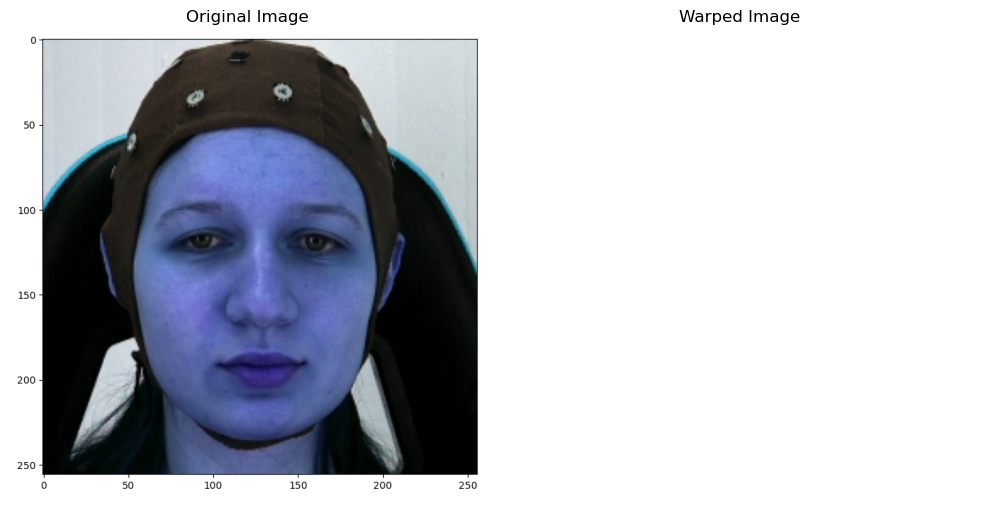

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread("output.png")  # Replace with your image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for correct display

# Define the homography matrix H
# H = np.array([[-1.03182577,  0.03986237,  1.0453101 ],
#               [ 0.05644938, -1.0457068,   1.04945552],
#               [ 0.10586107,  0.07890118,  1.        ]])  # Replace this with your matrix
# Warp the image using the homography matrix
height, width = image.shape[:2]  # Get original image dimensions
H = np.array([[ 0.87091375, -0.03364587,  0.04502736,],
              [-0.04764618,  0.88263009,  0.05081028,],
              [-0.08935219, -0.06659662,  1.    ]])
warped_image = cv2.warpPerspective(image, H, (width, height))

# warped_image = face_extractor.warp_face(source_img=image,
#                                         target_img=image,
#                                         src_points=centered_lm,
#                                         tgt_points=reference_landmarks)
# Plot the original and warped images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Warped Image")
plt.imshow(warped_image)
plt.axis("off")

plt.tight_layout()
plt.show()


In [3]:
avg_time = 5
h = int(8700 * avg_time / 60 / 60)
s = (8700 * avg_time / 60) % 60
print(f'Total time: {h:.0f} h {s:.0f} m')

Total time: 12 h 5 m


# Code

20 participants who did not react visibly to the applied pain stimuli:
- ID:27, 082315_w_60 
- ID:28, 082414_m_64
- ID:32, 082909_m_47
- ID:33, 083009_w_42
- ID:34, 083013_w_47
- ID:35, 083109_m_60
- ID:36, 083114_w_55
- ID:39, 091914_m_46
- ID:40, 092009_m_54
- ID:41, 092014_m_56
- ID:42, 092509_w_51
- ID:44, 092714_m_64
- ID:51, 100514_w_51
- ID:53, 100914_m_39
- ID:55, 101114_w_37
- ID:56, 101209_w_61
- ID:61, 101809_m_59
- ID:64, 101916_m_40
- ID:74, 111313_m_64
- ID:87, 120614_w_61

In [ ]:
%load_ext autoreload
%autoreload 2
import custom.tools as tools
import custom.scripts as scripts
import os
import time
# OK finish the video clip, start to create plot list_same_clip_positions many people
# try to combine plot and video in one
folder_tsne_results = os.path.join('tsne_Results',f'test_{str(int(time.time()))}')
folder_path_features = os.path.join('partA','video','features','samples_16')

if not os.path.exists(folder_tsne_results):
    os.makedirs(folder_tsne_results)

# stoic subjects = [27,28,32,33,34,35,36,39,40,41,42,44,51,53,55,56,61,64,74,87]
subject_id_list = [1]
clip_list = [0,1,2,3,4,5,6,7]
class_list = [4,3,2,1,0]
sample_id_list = None
sliding_windows =  16
legend_label = 'clip' # can be clip, subject and class    
scripts.plot_and_generate_video(folder_path_features=folder_path_features,
                                folder_path_tsne_results=folder_tsne_results,
                                subject_id_list=subject_id_list,
                                clip_list=clip_list,
                                legend_label=legend_label,
                                class_list=class_list,
                                sliding_windows=sliding_windows,
                                # plot_only_sample_id_list=sample_id_list,
                                plot_third_dim_time=False,
                                create_video=True,
                                apply_pca_before_tsne=False,
                                tsne_n_component=2,
                                sort_elements=True,
                                cmap='copper')


/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:459: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/home/v

dict_all_features["list_subject_id"] shape torch.Size([69600])
Elasped time to get all features:  0.049924373626708984
list_frames torch.Size([800, 16])
list_sample_id torch.Size([800])
list_video_path (800,)
list_feature torch.Size([800, 8, 1, 1, 768])
list_idx_list_frames (800,)
list_y_gt torch.Size([800])
TSNE_X.shape: torch.Size([800, 8, 1, 1, 768])
Using CPU
Start t-SNE computation...
X_tsne shape: (800, 2)
Plot saved to tsne_Results/test_1734624702/_.png
axis_dict {'min_x': -45.911114586688164, 'min_y': -55.54092918217133, 'max_x': 46.468452529475016, 'max_y': 48.627928252559585}
Plot saved to tsne_Results/test_1734624702/tsne_plot_16_clip/sliding_16_tot-subjects_1__clips_[0, 1, 2, 3, 4, 5, 6, 7]__classes_[4, 3, 2, 1, 0]_clip.png
Elapsed time to get all plots: 85.62082552909851 s
Generating video...
video_path: partA/video/video/071309_w_21/071309_w_21-PA4-002.mp4
video_path: partA/video/video/071309_w_21/071309_w_21-PA4-003.mp4
Processed 10/800 videos
video_path: partA/video/vid

: 

In [1]:
import custom.tools as tools  
import os
dict_data=tools.load_dict_data(saving_folder_path=os.path.join('partA','video','features','samples_16'))
for k,v in dict_data.items():
    print(k,v.shape)

/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:459: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/home/v

list_labels torch.Size([69600])
features torch.Size([69600, 8, 1, 1, 768])
list_path (69600,)
list_sample_id torch.Size([69600])
list_frames torch.Size([69600, 16])
list_subject_id torch.Size([69600])


In [ ]:
%load_ext autoreload
%autoreload 2
from custom.dataset import customDataset
from custom.backbone import backbone
from custom.helper import CLIPS_REDUCTION,EMBEDDING_REDUCTION,MODEL_TYPE,SAMPLE_FRAME_STRATEGY, HEAD
import torch
from torch.utils.data import DataLoader
import numpy as np
import os
from transformers import AutoImageProcessor

model_type = MODEL_TYPE.VIDEOMAE_v2_S
pooling_embedding_reduction = EMBEDDING_REDUCTION.MEAN_SPATIAL
pooling_clips_reduction = CLIPS_REDUCTION.NONE
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW

path_dataset = os.path.join('partA','video','video')
path_labels = os.path.join('partA','starting_point','samples.csv')

def _extract_features(dataset,path_csv_dataset,batch_size_feat_extraction,backbone):
  """
  Extract features from the dataset specified by the CSV file path.

  Args:
    path_csv_dataset (str): Path to the CSV file containing dataset information.
    batch_size (int, optional): Number of samples per batch to load. Default is 2.

  Returns:
    dict: A dictionary containing the following keys:
      - 'features' (torch.Tensor): shape [n_video * n_clips, temporal_dim=8, patch_h, patch_w, emb_dim].
      - 'list_labels' (torch.Tensor): shape [n_video * n_clips].
      - 'list_subject_id' (torch.Tensor): shape (n_video * n_clips).
      - 'list_sample_id' (torch.Tensor): shape (n_video * n_clips).
      - 'list_path' (np.ndarray): shape (n_video * n_clips,).
      - 'list_frames' (torch.Tensor): shape [n_video * n_clips, n_frames].

  """
  
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  print(f"extracting features using.... {device}")
  list_features = []
  list_labels = []
  list_subject_id = []
  list_sample_id = []
  list_path = []
  list_frames = []
  count = 0
  dataset.set_path_labels(path_csv_dataset)
  dataloader = DataLoader(dataset, 
                          batch_size=batch_size_feat_extraction,
                          # num_workers=1,
                          shuffle=False,
                          collate_fn=dataset._custom_collate_fn)
  # move the model to the device
  backbone.model.to(device)
  backbone.model.eval()
  with torch.no_grad():
    # start_total_time = time.time()
    start = time.time()
    for data, labels, subject_id,sample_id, path, list_sampled_frames in dataloader:
      #############################################################################################################
      # data shape -> [nr_clips, clip_length=16, channels=3, H=224, W=224]
      # 
      # nr_clips  = floor((total_frames-clip_length=16)/stride_window) + 1
      #           BIOVID -> floor((138-16)/4)) + 1 = 31
      # 
      # self.backbone.model ->   85 MB (small_model), 
      #                         400 MB (base_model), 
      #                           4 GB (giant_model)
      # 
      # video_feat_size [nr_video,8,768] => 8700 * 8 * 768 * 4 = 204 MB
      #############################################################################################################
      # print(f'Elapsed time for {batch_size} samples: {time.time() - start}')
      print(f'data shape {data.shape}')
      data = data.to(device)
      with torch.no_grad():
    # Extract features from clips -> return [B, clips/tubelets, W/patch_w, H/patch_h, emb_dim] 
        feature = backbone.forward_features(x=data)
      # feature -> [2, 8, 1, 1, 384]
      list_frames.append(list_sampled_frames)
      list_features.append(feature.detach().cpu())
      list_labels.append(labels)
      list_sample_id.append(sample_id)
      list_subject_id.append(subject_id)
      list_path.append(path)
      count += 1
      # if count % 10 == 0:
      print(f'Batch {count}/{len(dataloader)}')
      print(f' Time {int((time.time() - start)/60)} m : {int((time.time() - start)%60)} s')
      print(f' GPU:\n  Free : {torch.cuda.mem_get_info()[0]/1024/1024/1024:.2f} GB \n  total: {torch.cuda.mem_get_info()[1]/1024/1024/1024:.2f} GB')
      del data, feature
      torch.cuda.empty_cache()
      # start = time.time()
  # print(f'Elapsed time for total feature extraction: {time.time() - start_total_time}')
  # print('Feature extraceton done')
  backbone.model.to('cpu')
  # print('backbone moved to cpu')
  # print(f'torch.cat features {torch.cat(list_features,dim=0).shape}')
  dict_data = {
    'features': torch.cat(list_features,dim=0),  # [n_video * n_clips, temporal_dim=8, patch_h, patch_w, emb_dim] 630GB
    'list_labels': torch.cat(list_labels,dim=0),  # [n_video * n_clips] 8700 * 10 * 4 = 340 KB
    'list_subject_id': torch.cat(list_subject_id).squeeze(),  # (n_video * n_clips) 8700 * 10 * 4 = 340 KB
    'list_sample_id': torch.cat(list_sample_id),  # (n_video * n_clips) 8700 * 10 * 4 = 340 KB
    'list_path': np.concatenate(list_path),  # (n_video * n_clips,) 8700 * 10 * 4 = 340 KB
    'list_frames': torch.cat(list_frames,dim=0)  # [n_video * n_clips, n_frames] 8700 * 10 * 4 = 340 KB
  }

  return dict_data 

preprocess = AutoImageProcessor.from_pretrained(os.path.join("local_model_directory","preprocessor_config.json"))
custom_ds = customDataset(path_dataset=path_dataset,
                          path_labels=path_labels,
                          sample_frame_strategy=sample_frame_strategy,
                          stride_window=4,
                          preprocess=preprocess,
                          clip_length=16)
backbone_model = backbone(model_type=model_type)

dict_data = _extract_features(dataset=custom_ds,
                              path_csv_dataset=path_labels,
                              batch_size_feat_extraction=1,
                              backbone=backbone_model)

In [1]:
%load_ext autoreload
%autoreload 2
from custom.helper import CLIPS_REDUCTION,EMBEDDING_REDUCTION,MODEL_TYPE,SAMPLE_FRAME_STRATEGY, HEAD
import os
from custom.model import Model_Advanced
from transformers import AutoImageProcessor
from custom.head import HeadSVR, HeadGRU
import time
import torch.nn as nn
import torch.optim as optim
import custom.scripts as scripts

model_type = MODEL_TYPE.VIDEOMAE_v2_S
pooling_embedding_reduction = EMBEDDING_REDUCTION.MEAN_SPATIAL
pooling_clips_reduction = CLIPS_REDUCTION.NONE
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW
# path_dict ={
#   'all' : os.path.join('partA','starting_point','samples.csv'),
  # 'train' : os.path.join('partA','starting_point','train_21.csv'),
  # 'val' : os.path.join('partA','starting_point','val_26.csv'),
  # 'test' : os.path.join('partA','starting_point','test_5.csv')
# }
path_dataset = os.path.join('partA','video','video')  
path_cvs_dataset = os.path.join('partA','starting_point','samples.csv')
head = HEAD.GRU
# if head == 'GRU':
params = {
  'hidden_size': 1024,
  'num_layers': 1,
  'dropout': 0.0,
  'input_size': 768 * 8 # can be 384  (small), 768  (base), 1408  (large) [temporal_dim considered as input sequence for GRU]
                    # can be 384*8(small), 768*8(base), 1408*8(large) [temporal_dim considered feature in GRU] 
}

preprocess = AutoImageProcessor.from_pretrained(os.path.join("local_model_directory","preprocessor_config.json"))
stride_window_in_video = 4
model_advanced = scripts.run_train_test(model_type=model_type, 
                      pooling_embedding_reduction=pooling_embedding_reduction, 
                      pooling_clips_reduction=pooling_clips_reduction, 
                      sample_frame_strategy=sample_frame_strategy, 
                      path_csv_dataset=path_cvs_dataset, 
                      path_video_dataset=path_dataset,
                      head=head,
                      stride_window_in_video=stride_window_in_video, 
                      head_params=params,
                      preprocess=preprocess,
                      k_fold = 5,
                      epochs = 5,
                      train_size=0.8,
                      test_size=0.1,
                      val_size=0.1,
                      batch_size_training=1024,
                      batch_size_feat_extraction=8,  
                      criterion = nn.L1Loss(),
                      optimizer_fn = optim.SGD,
                      lr = 0.0001,
                      random_state_split_dataset=42,
                      only_train=False,
                      is_save_features_extracted=False, 
                      is_validation=True,
                      is_plot_dataset_distribution=True,
                      is_plot_loss=True,
                      is_plot_tsne_backbone_feats=True,
                      is_plot_tsne_head_pred=True,
                      is_plot_tsne_gru_feats=True,
                      is_create_video_prediction=True,
                      is_create_video_prediction_per_video=True,
                      is_round_output_loss=False,
                      is_shuffle_training_batch=True,
                      is_shuffle_video_chunks=False,
                      is_download_if_unavailable=False
                      )

/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:459: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/home/v

Set path_labels: partA/starting_point/samples.csv
Start training phase the model at history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734711243
 list_splits_idxs [array([   0,    1,    2, ..., 8197, 8198, 8199]), array([ 100,  101,  102, ..., 8297, 8298, 8299]), array([ 200,  201,  202, ..., 8397, 8398, 8399]), array([ 300,  301,  302, ..., 8697, 8698, 8699]), array([ 400,  401,  402, ..., 8597, 8598, 8599])]
CSV saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734711243/train_GRU/k0_cross_val/test.csv
CSV saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734711243/train_GRU/k0_cross_val/val.csv
CSV saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734711243/train_GRU/k0_cross_val/train.csv
training using validation set
Extracting features...
csv_path:history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734711243/train_GRU/k0_cross_val/train.csv
Loading features from SSD...


: 

In [1]:
import cv2
import time

def process_video_with_cpu(video_path):
    """Read video frames using CPU."""
    print("Processing video with CPU...")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    start_time = time.time()
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Process frame (no operation in this example)
        frame_count += 1

    end_time = time.time()
    cap.release()
    print(f"CPU: Processed {frame_count} frames in {end_time - start_time:.2f} seconds.")

def process_video_with_gpu(video_path):
    """Read video frames using GPU."""
    print("Processing video with GPU...")
    cap = cv2.VideoCapture(video_path, cv2.CAP_FFMPEG)
    # Enable GPU decoding
    if cv2.cuda.getCudaEnabledDeviceCount() > 0:
        gpu_cap = cv2.cuda.createVideoReader(video_path)
    else:
        print("Error: No CUDA-enabled GPU found.")
        return

    start_time = time.time()
    frame_count = 0

    while True:
        ret, gpu_frame = gpu_cap.nextFrame()
        if not ret:
            break
        # Download frame from GPU to CPU (if needed)
        frame = gpu_frame.download()
        # Process frame (no operation in this example)
        frame_count += 1

    end_time = time.time()
    print(f"GPU: Processed {frame_count} frames in {end_time - start_time:.2f} seconds.")

if __name__ == "__main__":
    video_path = "partA/video/video/071313_m_41/071313_m_41-BL1-081.mp4"  # Replace with the path to your video file
    
    # CPU processing
    process_video_with_cpu(video_path)
    
    # GPU processing
    process_video_with_gpu(video_path)
    

Processing video with CPU...
CPU: Processed 138 frames in 0.17 seconds.
Processing video with GPU...


AttributeError: module 'cv2.cuda' has no attribute 'createVideoReader'

In [1]:
import cv2
print(cv2.getBuildInformation())



General configuration for OpenCV 4.10.0 =====================================
  Version control:               4.10.0

  Extra modules:
    Location (extra):            /home/villi/opencv_contrib/modules
    Version control (extra):     4.10.0

  Platform:
    Timestamp:                   2025-01-12T22:22:40Z
    Host:                        Linux 6.8.0-51-generic x86_64
    CMake:                       3.22.1
    CMake generator:             Unix Makefiles
    CMake build tool:            /usr/bin/gmake
    Configuration:               Release

  CPU/HW features:
    Baseline:                    SSE SSE2 SSE3
      requested:                 SSE3
    Dispatched code generation:  SSE4_1 SSE4_2 FP16 AVX AVX2 AVX512_SKX
      requested:                 SSE4_1 SSE4_2 AVX FP16 AVX2 AVX512_SKX
      SSE4_1 (18 files):         + SSSE3 SSE4_1
      SSE4_2 (2 files):          + SSSE3 SSE4_1 POPCNT SSE4_2
      FP16 (1 files):            + SSSE3 SSE4_1 POPCNT SSE4_2 FP16 AVX
      AVX (9 files

In [ ]:
%autoreload 2
import custom.scripts as scripts

model_advanced.dataset.stride_window = 40
scripts.predict_per_video(
    path_csv='partA/starting_point/samples.csv',
    sample_ids=[10,35],
    model_advanced=model_advanced,
    root_folder_path='history_run/VIDEOMAE_v2_B_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733007378/train_GRU/video',
)

In [ ]:
import os

def set_working_directory():
  target_dir = 'PainAssessmentVideo'
  current_dir = os.getcwd()
  if os.path.split(current_dir)[-1] != target_dir:
    while os.path.split(current_dir)[-1] != target_dir:
      current_dir = os.path.dirname(current_dir)
      if current_dir == os.path.dirname(current_dir):  # reached the root directory
        raise FileNotFoundError(f"{target_dir} not found in the directory tree. Please set PainAssessmentVideo as current working directory.")
    os.chdir(current_dir)
  print(f"Current working directory set to: {os.getcwd()}")

def create_folder(path):
  if not os.path.exists(path):
    os.makedirs(path)
    print(f'Folder created: {path}')
  else:
    print(f'Folder already exists: {path}')                                                                                       